# **Importación**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# **Drive**

Se conecta al drive para leer el archivo desde alli

In [2]:
from google.colab import drive
drive.mount('/content/drive')

#url del archivo
url_train_file = '/content/drive/MyDrive/Colab Notebooks/train.csv'
url_test_file  = '/content/drive/MyDrive/Colab Notebooks/test.csv'

df_train = pd.read_csv(url_train_file)
df_test = pd.read_csv(url_test_file)

Mounted at /content/drive


#**Variables Categoricas**

In [3]:
ccols = [i for i in df_train.columns if not i in df_train._get_numeric_data()]
print (ccols)

['ESTU_PRGM_ACADEMICO', 'ESTU_PRGM_DEPARTAMENTO', 'ESTU_VALORMATRICULAUNIVERSIDAD', 'ESTU_HORASSEMANATRABAJA', 'FAMI_ESTRATOVIVIENDA', 'FAMI_TIENEINTERNET', 'FAMI_EDUCACIONPADRE', 'FAMI_TIENELAVADORA', 'FAMI_TIENEAUTOMOVIL', 'ESTU_PRIVADO_LIBERTAD', 'ESTU_PAGOMATRICULAPROPIO', 'FAMI_TIENECOMPUTADOR', 'FAMI_TIENEINTERNET.1', 'FAMI_EDUCACIONMADRE', 'RENDIMIENTO_GLOBAL']


#**CORRELACIÓN**


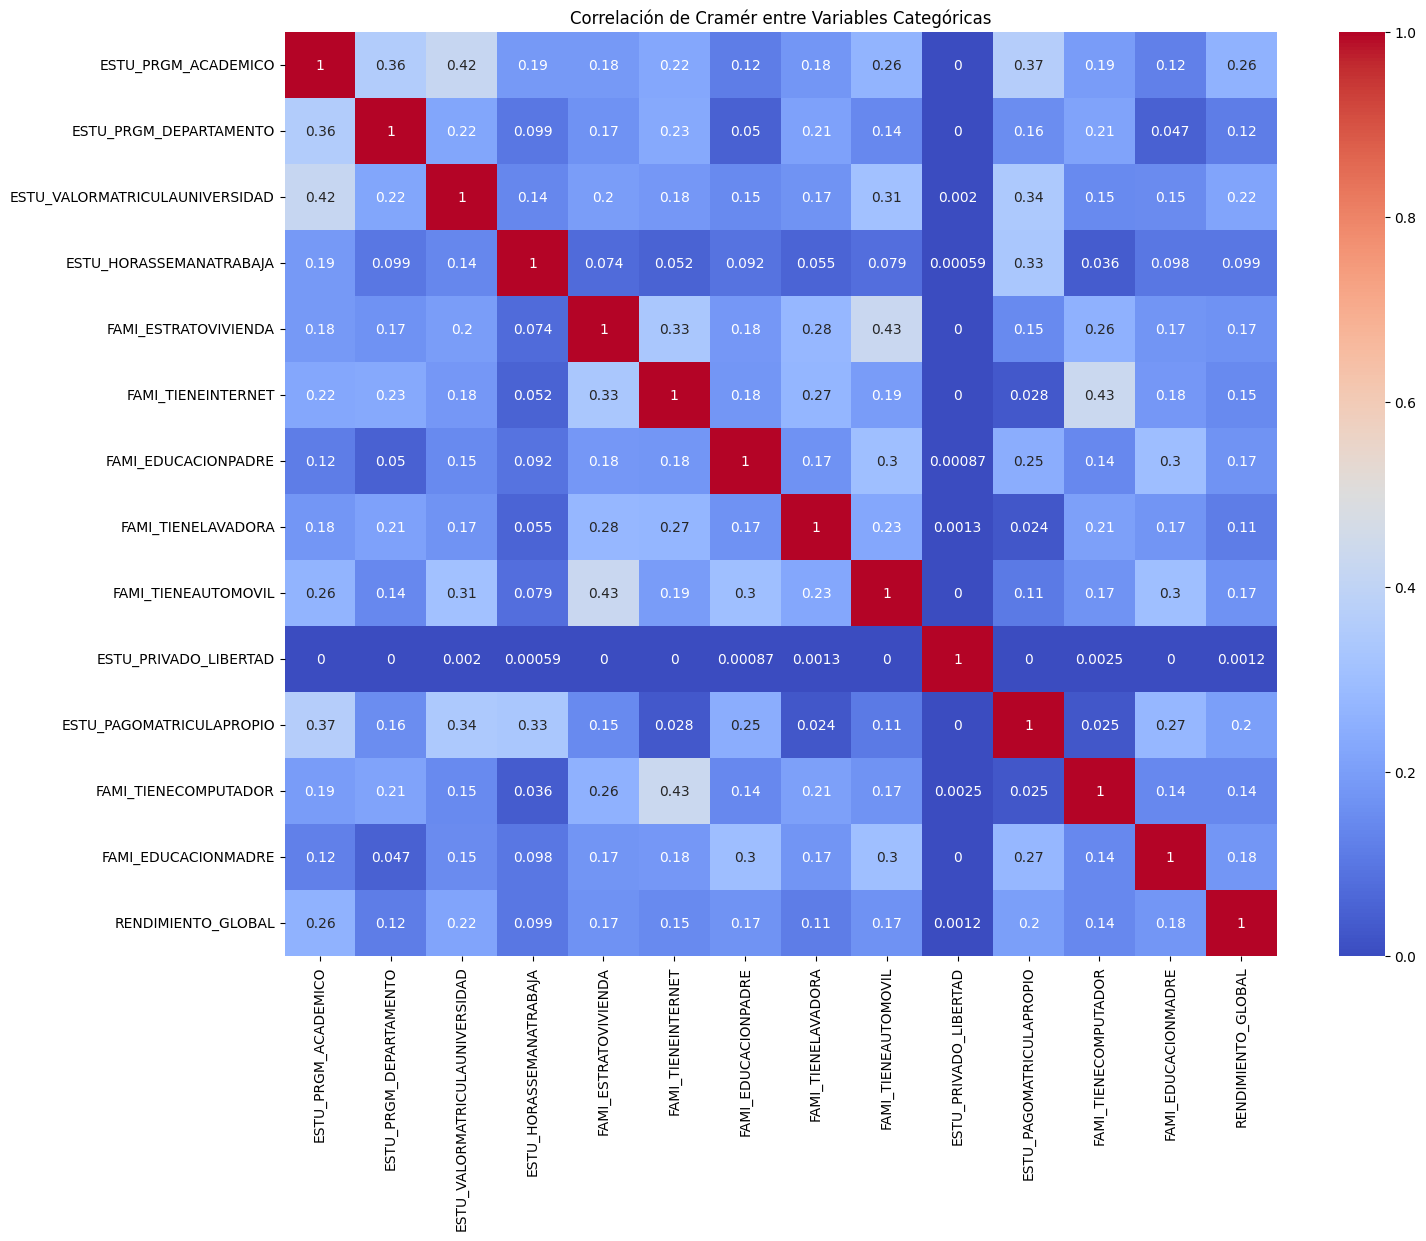

In [4]:
# Lista de variables categóricas
categorical_columns = [
    'ESTU_PRGM_ACADEMICO', 'ESTU_PRGM_DEPARTAMENTO', 'ESTU_VALORMATRICULAUNIVERSIDAD',
    'ESTU_HORASSEMANATRABAJA', 'FAMI_ESTRATOVIVIENDA', 'FAMI_TIENEINTERNET',
    'FAMI_EDUCACIONPADRE', 'FAMI_TIENELAVADORA', 'FAMI_TIENEAUTOMOVIL',
    'ESTU_PRIVADO_LIBERTAD', 'ESTU_PAGOMATRICULAPROPIO', 'FAMI_TIENECOMPUTADOR',
     'FAMI_EDUCACIONMADRE', 'RENDIMIENTO_GLOBAL'
]

# Asegurarse de que todas las columnas categóricas estén codificadas correctamente
for col in categorical_columns:
    df_train[col] = df_train[col].astype('category')

# Función para calcular la correlación de Cramér
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1)*(r - 1))/(n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Crear un DataFrame para almacenar los resultados de la correlación de Cramér
correlation_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

# Calcular la correlación de Cramér para cada par de variables categóricas
for col1 in categorical_columns:
    for col2 in categorical_columns:
        if col1 == col2:
            correlation = 1.0  # La correlación de una variable consigo misma es 1
        else:
            correlation = cramers_v(df_train[col1], df_train[col2])
        correlation_matrix.loc[col1, col2] = correlation

# Convertir los valores a tipo float
correlation_matrix = correlation_matrix.astype(float)

# Visualizar la matriz de correlación
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Correlación de Cramér entre Variables Categóricas')
plt.show()

#**Reemplazando valores perdidos**
Para los valores perdidos en cada columna se reemplazara por el valor que mas se repite

**ANÁLISIS**

*   La columna **ESTU_PRIVADO_LIBERTAD** no es necesaria ya que no tiene mayor diferencia en sus valores
*   Se elimina la columna **FAMI_TIENEINTERNET.1**, ya que se encuentra repetida


In [5]:
df_train = df_train.drop('ESTU_PRIVADO_LIBERTAD', axis=1)
df_train = df_train.drop('FAMI_TIENEINTERNET.1', axis=1)

In [6]:
# Función para imputar valores faltantes con la moda de cada grupo
def impute_with_mode(df, group_col, target_col):
    mode_by_group = df.groupby(group_col)[target_col].apply(lambda x: x.mode()[0] if not x.mode().empty else None)
    df[target_col] = df.apply(
        lambda row: mode_by_group[row[group_col]] if pd.isnull(row[target_col]) else row[target_col], axis=1
    )

**Para ESTU_VALORMATRICULAUNIVERSIDAD se decide reemplazar por la moda del ESTU_PRGM_ACADEMICO**

In [7]:
# Imputar los valores faltantes en 'ESTU_VALORMATRICULAUNIVERSIDAD' de acuerdo a 'ESTU_PRGM_ACADEMICO'
impute_with_mode(df_train, 'ESTU_PRGM_ACADEMICO', 'ESTU_VALORMATRICULAUNIVERSIDAD')
# Calcular la moda de 'ESTU_VALORMATRICULAUNIVERSIDAD'
mode_valormatricula = df_train['ESTU_VALORMATRICULAUNIVERSIDAD'].mode()[0]

# Llenar los valores faltantes en 'ESTU_VALORMATRICULAUNIVERSIDAD' con la moda general
df_train['ESTU_VALORMATRICULAUNIVERSIDAD'].fillna(mode_valormatricula, inplace=True)


**Para FAMI_ESTRATOVIVIENDA se decide reemplazar por la moda del ESTU_VALORMATRICULAUNIVERSIDAD**

In [8]:
# Imputar los valores faltantes en 'ESTU_VALORMATRICULAUNIVERSIDAD' de acuerdo a 'ESTU_PRGM_ACADEMICO'
impute_with_mode(df_train, 'ESTU_VALORMATRICULAUNIVERSIDAD', 'FAMI_ESTRATOVIVIENDA')

**Para ESTU_HORASSEMANATRABAJA se decide reemplazar por la moda del FAMI_ESTRATOVIVIENDA**

In [9]:
impute_with_mode(df_train, 'FAMI_ESTRATOVIVIENDA', 'ESTU_HORASSEMANATRABAJA')

**Para FAMI_EDUCACIONMADRE y FAMI_EDUCACIONPADRE se decide reemplazar por la moda del FAMI_ESTRATOVIVIENDA**

In [10]:
impute_with_mode(df_train, 'FAMI_ESTRATOVIVIENDA', 'FAMI_EDUCACIONPADRE')
impute_with_mode(df_train, 'FAMI_ESTRATOVIVIENDA', 'FAMI_EDUCACIONMADRE')

In [11]:
impute_with_mode(df_train, 'FAMI_ESTRATOVIVIENDA', 'FAMI_TIENELAVADORA')

In [12]:
impute_with_mode(df_train, 'FAMI_TIENELAVADORA', 'FAMI_TIENEINTERNET')

In [13]:
impute_with_mode(df_train, 'FAMI_ESTRATOVIVIENDA', 'FAMI_TIENEAUTOMOVIL')

**Para ESTU_PAGOMATRICULAPROPIO  se decide reemplazar por la moda del ESTU_PRGM_ACADEMICO**

In [14]:
impute_with_mode(df_train, 'ESTU_PRGM_ACADEMICO', 'ESTU_PAGOMATRICULAPROPIO')
mode_valormatricula = df_train['ESTU_PAGOMATRICULAPROPIO'].mode()[0]
df_train['ESTU_PAGOMATRICULAPROPIO'].fillna(mode_valormatricula, inplace=True)

In [15]:
impute_with_mode(df_train, 'FAMI_TIENEINTERNET', 'FAMI_TIENECOMPUTADOR')

In [16]:
#comprobación de valores faltantes
pd.isnull(df_train).sum()

ID                                0
PERIODO                           0
ESTU_PRGM_ACADEMICO               0
ESTU_PRGM_DEPARTAMENTO            0
ESTU_VALORMATRICULAUNIVERSIDAD    0
ESTU_HORASSEMANATRABAJA           0
FAMI_ESTRATOVIVIENDA              0
FAMI_TIENEINTERNET                0
FAMI_EDUCACIONPADRE               0
FAMI_TIENELAVADORA                0
FAMI_TIENEAUTOMOVIL               0
ESTU_PAGOMATRICULAPROPIO          0
FAMI_TIENECOMPUTADOR              0
FAMI_EDUCACIONMADRE               0
RENDIMIENTO_GLOBAL                0
dtype: int64

#Función de limpieza del dataflame

In [17]:
df_train = pd.read_csv(url_train_file)
df_test = pd.read_csv(url_test_file)

In [18]:
def clean_data(df):
  #elimición de columnas
  df = df.drop('ESTU_PRIVADO_LIBERTAD', axis=1)
  df = df.drop('FAMI_TIENEINTERNET.1', axis=1)

  #reemplazando valores perdidos
  #reemplazando valores perdidos

  impute_with_mode(df, 'ESTU_PRGM_ACADEMICO', 'ESTU_VALORMATRICULAUNIVERSIDAD')
  mode_valormatricula = df['ESTU_VALORMATRICULAUNIVERSIDAD'].mode()[0]
  df['ESTU_VALORMATRICULAUNIVERSIDAD'].fillna(mode_valormatricula, inplace=True)


  impute_with_mode(df, 'ESTU_VALORMATRICULAUNIVERSIDAD', 'FAMI_ESTRATOVIVIENDA')

  impute_with_mode(df, 'FAMI_ESTRATOVIVIENDA', 'ESTU_HORASSEMANATRABAJA')



  impute_with_mode(df, 'FAMI_ESTRATOVIVIENDA', 'FAMI_EDUCACIONPADRE')
  impute_with_mode(df, 'FAMI_ESTRATOVIVIENDA', 'FAMI_EDUCACIONMADRE')


  impute_with_mode(df, 'FAMI_ESTRATOVIVIENDA', 'FAMI_TIENELAVADORA')


  impute_with_mode(df, 'FAMI_TIENELAVADORA', 'FAMI_TIENEINTERNET')


  impute_with_mode(df, 'FAMI_ESTRATOVIVIENDA', 'FAMI_TIENEAUTOMOVIL')


  impute_with_mode(df, 'ESTU_PRGM_ACADEMICO', 'ESTU_PAGOMATRICULAPROPIO')
  mode_valormatricula = df['ESTU_PAGOMATRICULAPROPIO'].mode()[0]
  df['ESTU_PAGOMATRICULAPROPIO'].fillna(mode_valormatricula, inplace=True)


  impute_with_mode(df, 'FAMI_TIENEINTERNET', 'FAMI_TIENECOMPUTADOR')

  #normalización de valores
  df['FAMI_ESTRATOVIVIENDA'].replace(['Estrato 1','Estrato 2','Estrato 3','Estrato 4','Estrato 5','Estrato 6','Sin Estrato'],[1,2,3,4,5,6,0],inplace=True)
  #df['RENDIMIENTO_GLOBAL'].replace(['bajo','medio-bajo','medio-alto','alto'],[1,2,3,4],inplace=True)

  df["FAMI_TIENEINTERNET"] = df["FAMI_TIENEINTERNET"].replace({'Si': 1, 'No': 0})
  df["FAMI_TIENELAVADORA"] = df["FAMI_TIENELAVADORA"].replace({'Si': 1, 'No': 0})
  df["FAMI_TIENEAUTOMOVIL"] = df["FAMI_TIENEAUTOMOVIL"].replace({'Si': 1, 'No': 0})
  df["ESTU_PAGOMATRICULAPROPIO"] = df["ESTU_PAGOMATRICULAPROPIO"].replace({'Si': 1, 'No': 0})
  df["FAMI_TIENECOMPUTADOR"] = df["FAMI_TIENECOMPUTADOR"].replace({'Si': 1, 'No': 0})

  df['ESTU_VALORMATRICULAUNIVERSIDAD'].replace(['No pagó matrícula'],[0],inplace=True)
  df['ESTU_VALORMATRICULAUNIVERSIDAD'].replace(['Menos de 500 mil'],[1],inplace=True)
  df['ESTU_VALORMATRICULAUNIVERSIDAD'].replace(['Entre 500 mil y menos de 1 millón'],[2],inplace=True)
  df['ESTU_VALORMATRICULAUNIVERSIDAD'].replace(['Entre 1 millón y menos de 2.5 millones'],[3],inplace=True)
  df['ESTU_VALORMATRICULAUNIVERSIDAD'].replace(['Entre 2.5 millones y menos de 4 millones'],[4],inplace=True)
  df['ESTU_VALORMATRICULAUNIVERSIDAD'].replace(['Entre 4 millones y menos de 5.5 millones'],[5],inplace=True)
  df['ESTU_VALORMATRICULAUNIVERSIDAD'].replace(['Entre 5.5 millones y menos de 7 millones'],[6],inplace=True)
  df['ESTU_VALORMATRICULAUNIVERSIDAD'].replace(['Más de 7 millones'],[7],inplace=True)

  df['ESTU_HORASSEMANATRABAJA'].replace(['0','Menos de 10 horas','Entre 11 y 20 horas','Entre 21 y 30 horas','Más de 30 horas'],[0,1,2,3,4],inplace=True)

  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].str.replace('PROFESIONAL EN ', '')

  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'INGENIERIA' if x.startswith('INGE') else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'LICENCIATURA' if x.startswith('LIC') or x.startswith('Lic') else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'ADMINISTRACION' if x.startswith('ADM')   else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'CONTADURIA' if x.startswith('CONT')   else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'COMUNICACION' if x.startswith('COMU')   else x)

  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'DEPORTE' if 'DEPORT'  in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'PSICOLOGIA' if 'PSIC' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'TRABAJO SOCIAL' if 'TRABAJO SOCIAL' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'DISEÑO' if 'DISE' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'TERAPIA' if 'TERAP' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'GASTRONOMIA' if 'GASTRON' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'VETERINARIA Y ZOOTECNIA' if 'ZOOTECNIA' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'NUTRICION' if 'NUTRIC' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'MARKETING' if ( 'MARKETING' in x or 'PUBLICIDAD' in x or 'MERCAD' in x) else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'MATEMATICAS Y ESTADISTICA' if ('MATE' in x or 'ESTA' in x) else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'ARTES' if 'ARTE' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'LITERATURA' if 'LITER' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'MUSICA' if ('MUS' in x or 'MÚS' in x) else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'ECONOMIA Y NEGOCIOS' if ('ECONO' in x or 'NEG' in x or 'COME' in x or 'FIN' in x) else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'CIENCIAS DE LA TIERRA' if 'GEO' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'CIENCIAS AUDIOVISUALES' if ('CINE' in x or 'RADIO' in x or 'TELEV' in x or 'AUDIOV' in x or 'FOTOG' in x) else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'DERECHO' if 'DERECHO' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'CIENCIAS POLITICAS' if ( 'POLIT' in x or 'POLÍT' in x) else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'INGENIERIA' if 'INGE' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'QUIMICA' if ('QUIM' in x or 'QUÍM' in x or 'QU¿M' in x) else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'CONSTRUCCION' if 'CONST' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'TURISMO' if 'TURIS' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'BIBLIOTECOLOGIA' if 'BIBLIO' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'FILOSOFIA' if 'FILOS' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'FILOLOGIA' if 'FILOL' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'ODONTOLOGIA' if 'ODONTOLOG' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'BIOLOGIA Y MICROBIOLOGIA' if 'BIOL' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'ECOLOGIA' if x.startswith('ECOL')   else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'BACTERIOLOGIA' if 'BACT' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].replace('ACUICULTURA', 'ACUICUlTURA')
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'CIENCIAS CULTURALES' if 'CULT' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'INSTRUMENTACION QUIRURGICA' if 'INSTRUMENTACION' in x else x)
  df['ESTU_PRGM_ACADEMICO'] = df['ESTU_PRGM_ACADEMICO'].apply(lambda x: 'CIENCIAS MARITIMAS Y AERONAUTICAS' if ('MILIT' in x or 'NAVALES' in x or 'NAU' in x) else x)


  # Calcula el conteo de cada valor en la columna 'ESTU_PRGM_ACADEMICO'
  conteo_valores = df['ESTU_PRGM_ACADEMICO'].value_counts()

  # Obtén los valores que tienen menos de N registros
  valores_menos_de_20 = conteo_valores[conteo_valores <= 20]
  valores_menos_de_20

  # Reemplaza los valores que tienen menos de N registros con 'OTRO PROGRAMA'
  for valor in valores_menos_de_20.index:
      df.loc[df['ESTU_PRGM_ACADEMICO'] == valor, 'ESTU_PRGM_ACADEMICO'] = 'OTRO PROGRAMA'

  df = pd.get_dummies(df, columns= ["ESTU_PRGM_ACADEMICO","ESTU_PRGM_DEPARTAMENTO","FAMI_EDUCACIONPADRE","FAMI_EDUCACIONMADRE"])
  df = df.astype(int)



  return df





In [19]:
# Definir la longitud del conjunto de datos de entrenamiento
lentr = len(df_train)

# Extraer las columnas de origen excluyendo la columna objetivo
source_cols = [i for i in df_train.columns if i != "RENDIMIENTO_GLOBAL"]

# Concatenar los conjuntos de datos de entrenamiento y prueba
all_data = pd.concat((df_train[source_cols], df_test[source_cols]))

# Restablecer el índice del DataFrame concatenado
all_data.index = range(len(all_data))

# Limpiar los datos usando una función personalizada clean_data
all_data = clean_data(all_data)

# Separar los datos limpios de nuevo en conjuntos de datos de entrenamiento y prueba
Xtrain, ytrain = all_data.iloc[:lentr].values, df_train["RENDIMIENTO_GLOBAL"].values
Xtest = all_data.iloc[lentr:].values


print(Xtrain.shape, ytrain.shape)
print(Xtest.shape)


(692500, 165) (692500,)
(296786, 165)


In [20]:
# Importar las bibliotecas necesarias
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# Definir el clasificador RandomForest
rf = RandomForestClassifier()
print (cross_val_score(rf, Xtrain, ytrain))


[0.39037545 0.38809386 0.3885704  0.39025271 0.3885704 ]


**Entrenar el modelo**

In [21]:
rf.fit(Xtrain, ytrain)
# Hacer predicciones con los datos de prueba
preds_ts = rf.predict(Xtest)
preds_ts

array(['alto', 'bajo', 'alto', ..., 'medio-alto', 'alto', 'alto'],
      dtype=object)

**Creación de dataframe de submission con las columnas ID y RENDIMIENTO_GLOBAL**

In [23]:
submission = pd.DataFrame([df_test.ID, pd.Series(preds_ts, name="RENDIMIENTO_GLOBAL")]).T
submission.head()

submission.to_csv("archivo_final.csv",index=False)

print("****** EJECUCIÓN FINALIZADA *******")

****** EJECUCIÓN FINALIZADA *******
